In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
from scipy.ndimage import shift
import itertools
import pickle
from pathlib import Path

from lmfit.models import GaussianModel, LinearModel

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak_LE.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()
#print(exampleObj)

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#import singularity_pulseSave as sps
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-lt-50keV.txt')

#pulse_struct = sps.parseEventList('../coin_analysis/data/r76_events_coincidencepeak.txt')

   SeriesNumber  EventNumber
0   72209162200        20309
1   72209162200        40339
2   72209162200        50269
3   72209162200        60108
4   72209162200        60849
5   72209162200        80307
6   72209162200       100246
7   72209162200       110588
8   72209162200       110617
9   72209162200       120647
[72209162200 72209171225 72209172155]
[  20309   40339   50269   60108   60849   80307  100246  110588  110617
  120647  120688  130460  140628  150823  160296  170423  180002  180423
  230432  240270  270221  340151  340912  380054  380186  390511  420391
  420816  430710  440168  480387  480389  500725  520930  540170  540903
  550322  560707  560931  570415  580008  580723  590121  610172  610663
  610684  640653  650751  670228  670650  690338  710437  740337  750334
  750490  760179  770287  780145  780259  780278  780628  800530  810923
  820568  840012  840222  850265  860663  880573  880913  910282  920809
  920948  930239  930872  940631  950888  960920  970767 10

In [5]:
coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])

def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)

In [6]:
# toggle plotting individual pulses
plot = False

In [7]:
def getPTPulse(pulses,series=72209162200,ev=20309,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        #print(mean)
        pulse = pulse-mean
        #print(pulse)
        #print(np.size(ptpulse))
        if(ccount==0):
            ptpulse=pulse
        else:
            ptpulse+=pulse
        ccount+=1
        
    return ptpulse

### Basic Discriminator

In [8]:
def getPTPulseCD(pulses,series=72209162200,ev=20309):
    
    pulse = getPTPulse(pulses, series, ev)

    #adding discriminator
    D = 100

    end_values = pulse[3997:]
    
    CD_pulse = shift(pulse, D, cval=np.nan)

    #adding the cut off values to the front of the new pulse
    CD_pulse[0:99] = end_values
    #print(new_pulse)
        
    return CD_pulse

In [9]:
getPTPulse(exampleObj)

array([-461.10785786, -466.10785786, -462.10785786, ..., -575.10785786,
       -580.10785786, -585.10785786])

In [10]:
loops = 0
time_reg = []
energies = []

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                    
            if (plot==True):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                   

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1

In [11]:
time_reg_array = np.asarray(time_reg)

delay = []
filt_energies = []

for i in range(len(time_reg_array)):
    #if (time_reg_array[i]-500) > 0:
    delay.append(time_reg_array[i]-500)
    filt_energies.append(energies[i])

#print(delay)
print(loops, len(delay))

1156 1156


1156


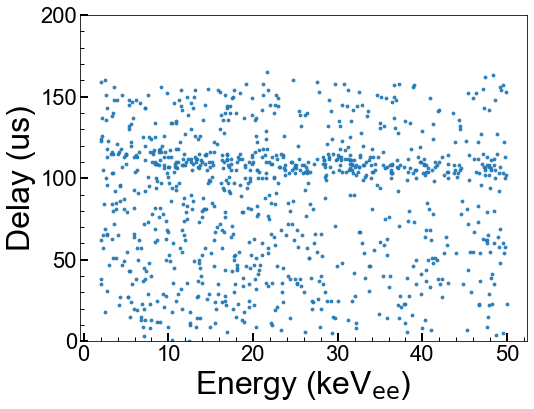

In [12]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
ax1 = axs

print(len(filt_energies))
#print(len(delay))

ax1.scatter(filt_energies, delay, marker='o', alpha=0.9, s=8)

ax1.set(xlabel="Energy (keV$_{\mathrm{ee}}$)", ylabel="Delay (us)")
    
#plt.xlim(0, 200)
plt.ylim(0,200)

#saving to output file
df = pd.DataFrame({'energy':filt_energies, 'delay':delay})

filepath = Path('output/below_50_dis.csv')  
df.to_csv(filepath, index=False)  

### Constant Fraction Discriminator

In [13]:
def getPTPulseCFD(pulses,series=72209162200,ev=20309):
        
    pulse = getPTPulse(pulses, series, ev)
    
    #CFD formula
    F = 0.5
    D = 100

    end_values = pulse[3997:]
    #print(end_values)
    new_pulse = shift(pulse, D, cval=np.nan)
    #print(new_pulse)

    #adding the cut off values to the front of the new pulse
    new_pulse[0:99] = end_values
    #print(new_pulse)

    CFD_pulse = F*(pulse)-new_pulse
    
    return CFD_pulse

In [14]:
getPTPulseCFD(exampleObj)

array([351.55392893, 343.05392893, 348.05392893, ..., 285.55392893,
       274.05392893, 278.55392893])

In [15]:
loops = 0
time_cfd = []
energies = []

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:

        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 50.5:
        #    continue
    
        shownpulses=0

        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCFD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        
        bshifted_pT = np.subtract(pT,yB)
        
        cross_pT = []
        
        for i in range(350, 750):
            cross_pT.append(bshifted_pT[i])
                
        #print(cross_pT)

        if(shownpulses>0):
                        
            crosses = np.isclose(cross_pT, 0, atol=100.0)
            #print(crosses)
            
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 400):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                best_cross = best_cross+350
                time_cfd.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                    
                    
            if (plot==True):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(np.subtract(pT, yB), label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,2000)
                #ax1.set_ylim(-10,10)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')

                #plt.suptitle('Event 0 on Z1 PA Channels')
                if(shownpulses > 0):
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            loops += 1

In [16]:
time_cfd_array = np.asarray(time_cfd)

delay_cfd = []
filt_energies = []

for i in range(len(time_cfd)):
    #if (time_cfd_array[i]-500) > 0:
    delay_cfd.append(time_cfd_array[i]-500)
    filt_energies.append(energies[i])

#print(delay_cfd)
print(loops, len(delay_cfd))

1156 1151


1151


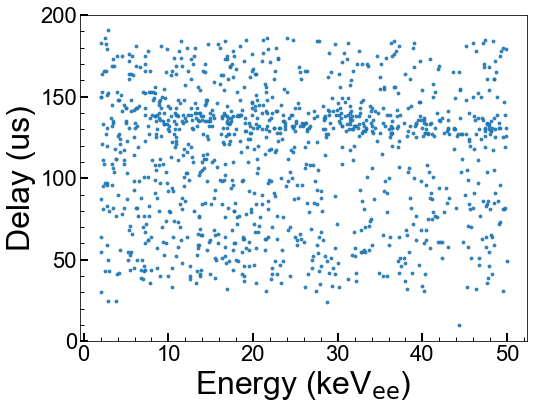

In [17]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
ax1 = axs

print(len(filt_energies))
#print(len(delay_cfd))

ax1.scatter(filt_energies, delay_cfd, marker='o', alpha=0.9, s=8)

ax1.set(xlabel="Energy (keV$_{\mathrm{ee}}$)", ylabel="Delay (us)")
    
#plt.xlim(0, 200)
plt.ylim(0,200)

#saving to output file
df = pd.DataFrame({'energy':filt_energies, 'delay':delay_cfd})

filepath = Path('output/below_50_cfd.csv')  
df.to_csv(filepath, index=False)  

### Reading in Original PTO Data for Overlay

In [18]:
cHE = (EkeV<50.0)

with open('data/r76-coinpeak-gt-50keV.txt', 'w') as f:
    for i,s in enumerate(series_nums):
        if(cHE[i]):
          f.write('{} {}\n'.format(s,event_nums[i]))

### Fitting 1D Hists as Gaussians

In [19]:
def fit_hist(fit_me, cen):
    
    fit_bins = np.linspace(-200,200,200)

    # setting up the fit model
    peak = GaussianModel()
    background = LinearModel()
    mod = peak + background

    counts, bin_edges = np.histogram(fit_me, bins=fit_bins)
    bin_widths = np.diff(bin_edges)
    x = bin_edges[:-1] + (bin_widths / 2)
    y = counts
    
    # generating fit parameters, intercept=y.min()
    pars = background.make_params(intercept=0.008, slope=0)
    pars += peak.guess(y, x=x, center=cen)
    final_fit = mod.fit(y, pars, x=x)
    #final_fit.plot_fit()
   
    center = final_fit.params['center'].value
    #center_err = final_fit.params['center'].stderr
    width = final_fit.params['fwhm'].value
    #width_err = final_fit.params['fwhm'].stderr

    return final_fit, center, width

### Comparing Discriminators

108.51801085321354 13.315227536809902
22.91751800823762 20.4620439817224


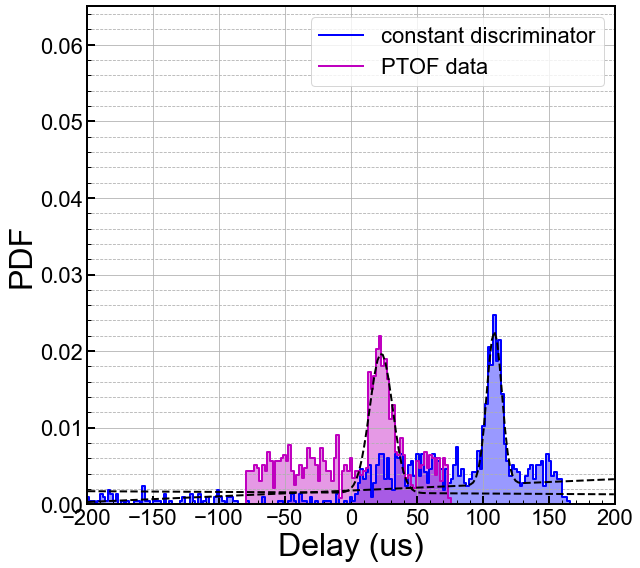

In [20]:
#filtered_delay = (delay>0)

qbins = np.linspace(-200,200,200)
xcq = (qbins[:-1] + qbins[1:]) / 2
n,nx = np.histogram(delay,bins=qbins)
n_org, nx_org = np.histogram(PTOFdelay[cHE],bins=qbins)


#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

yhist = n/np.sum(n)/np.diff(xcq)[0]

yhist_org = n_org/np.sum(n_org)/np.diff(xcq)[0]

# plotting new delays
ax1.step(xcq,yhist, where='mid',color='b', linestyle='-', \
            label='constant discriminator', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist,step='mid',facecolor='b',alpha=0.4, \
                 label='')

# plotting original delays
ax1.step(xcq,yhist_org, where='mid',color='m', linestyle='-', \
            label='PTOF data', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist_org,step='mid',facecolor='m',alpha=0.4, \
                 label='')

# fitting histograms
new_fit, new_center, new_width = fit_hist(delay, 110)
print(new_center, new_width)
org_fit, org_center, org_width = fit_hist(PTOFdelay[cHE], 25)
print(org_center, org_width)

# normalizing fits
new_fit_plot = new_fit.best_fit/np.sum(new_fit.best_fit)/np.diff(xcq)[0]
org_fit_plot = org_fit.best_fit/np.sum(org_fit.best_fit)/np.diff(xcq)[0]

ax1.plot(xcq, new_fit_plot, color = 'k', linestyle='--', label='')
ax1.plot(xcq, org_fit_plot, color = 'k', linestyle='--', label='')

#blue = '#118DFA'
ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(-200, 200) 
ax1.set_ylim(0.0, 0.065)
ax1.set_xlabel(r'Delay (us)')
ax1.set_ylabel('PDF')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/MSyieldHist_Figure3a.eps')
#plt.savefig('paper_figures/MSyieldHist_Figure3a.pdf')
plt.show()

134.18321695586647 15.005832622944162
22.91751800823762 20.4620439817224


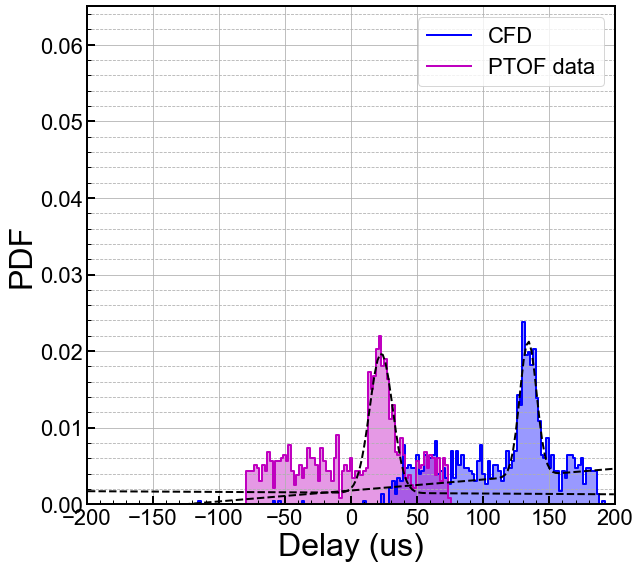

In [21]:
#filtered_delay_cfd = (delay_cfd>0)

qbins = np.linspace(-200,200,200)
xcq = (qbins[:-1] + qbins[1:]) / 2
n,nx = np.histogram(delay_cfd,bins=qbins)
n_org, nx_org = np.histogram(PTOFdelay[cHE],bins=qbins)

#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

yhist = n/np.sum(n)/np.diff(xcq)[0]

yhist_org = n_org/np.sum(n_org)/np.diff(xcq)[0]

# plotting new delays
ax1.step(xcq,yhist, where='mid',color='b', linestyle='-', \
            label='CFD', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist,step='mid',facecolor='b',alpha=0.4, \
                 label='')

# plotting original delays
ax1.step(xcq,yhist_org, where='mid',color='m', linestyle='-', \
            label='PTOF data', linewidth=2)
ax1.fill_between(xcq,np.zeros(np.shape(xcq)),yhist_org,step='mid',facecolor='m',alpha=0.4, \
                 label='')

# fitting histograms
new_fit, new_center, new_width = fit_hist(delay_cfd, 130)
print(new_center, new_width)
org_fit, org_center, org_width = fit_hist(PTOFdelay[cHE], 25)
print(org_center, org_width)

# normalizing fits
new_fit_plot = new_fit.best_fit/np.sum(new_fit.best_fit)/np.diff(xcq)[0]
org_fit_plot = org_fit.best_fit/np.sum(org_fit.best_fit)/np.diff(xcq)[0]

ax1.plot(xcq, new_fit_plot, color = 'k', linestyle='--', label='')
ax1.plot(xcq, org_fit_plot, color = 'k', linestyle='--', label='')

#blue = '#118DFA'
ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(-200, 200) 
ax1.set_ylim(0.0,0.065)
ax1.set_xlabel(r'Delay (us)')
ax1.set_ylabel('PDF')
#ax1.set_title('CFD')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/MSyieldHist_Figure3a.eps')
#plt.savefig('paper_figures/MSyieldHist_Figure3a.pdf')
plt.show()